Visualize detector 3d bb (in 2d) on nuscenes using dataloader

In [2]:
import sys
from PIL import Image
# sys.path.append("D:\Python_Projects\PhD_project")
sys.path.append('/home/dimitris/PhD/PhD/visualDet3D')
import pickle
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
#from visualDet3D.visualDet3D.data.kitti.dataset import *
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer
from numba import jit
from tqdm import tqdm
print('CUDA available: {}'.format(torch.cuda.is_available()))

# cfg = cfg_from_file('D:/Python_Projects/PhD_project/visualDet3D/config/config.py')
cfg = cfg_from_file('/home/dimitris/PhD/PhD/visualDet3D/config/config.py')
is_test_train = True

# checkpoint_name = 'D:/Python_Projects/PhD_project/visualDet3D/workdirs/Mono3D/checkpoint/GroundAware_pretrained.pth'
checkpoint_name = '/home/dimitris/PhD/PhD/visualDet3D/workdirs/Mono3D/checkpoint/GroundAware_pretrained.pth'

CUDA available: True


In [3]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [4]:
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

nuscenes run
Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.513 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
[[[ 29  25  22]
  [ 27  23  20]
  [ 24  20  19]
  ...
  [115 129 142]
  [115 129 142]
  [115 129 142]]

 [[ 23  19  16]
  [ 22  18  15]
  [ 23  19  18]
  ...
  [116 130 143]
  [116 130 143]
  [116 130 143]]

 [[ 17  16  12]
  [ 18  17  13]
  [ 20  19  17]
  ...
  [116 130 143]
  [116 130 143]
  [116 130 143]]

 ...

 [[ 58  57  52]
  [136 135 130]
  [124 123 118]
  ...
  [104 105 100]
  [104 105 100]
  [104 105 100]]

 [[ 56  55  50]
  [135 134 129]
  [125 124 119]
  ...
  [105 106 101]
  [105 106 101]
  [106 107 102]]

 [[ 54  53  48]
  [134 133 128]
  [126 125 120]
  ...
  [106 107 102]
  [107 108 103]
  [107 108 103]]]
[[1.26641720e+03 0.00000000e+00 8.

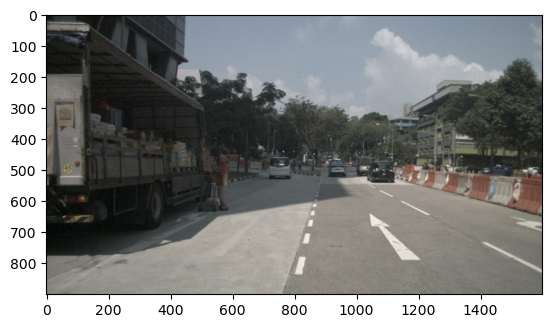

In [5]:
sys.path.append('/home/dimitris/PhD/PhD/nuscenes')
from torchvision import transforms
from devkit_dataloader.Dataloader import *

nusc_dataset = NuscenesDataset(nusc)
input_image, _ = nusc_dataset.__getitem__(1)
image = np.array(input_image)
calibr = nusc_dataset.get_calib(0)

print(image)
print(calibr)
plt.imshow(image)
plt.show()

In [6]:
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image

In [9]:
from visualDet3D.data.pipeline import build_augmentator

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

def collate_fn(batch):
    rgb_images = np.array([item["image"] for item in batch]) #[batch, H, W, 3]
    rgb_images = rgb_images.transpose([0, 3, 1, 2])
    calib = np.array([item["calib"] for item in batch])
    return torch.from_numpy(rgb_images).float(), torch.from_numpy(calib).float()

def compute_once(is_draw=True, is_test_train=True):
    transform = build_augmentator(cfg.data.test_augmentation)
    # print("calibr.copy", calibr.copy()) 
    transformed_image, transformed_P2 = transform(image.copy(), p2=calibr.copy())
    # print("transformedP2A", transformed_P2) 
    data = {'calib': transformed_P2,
                       'image': transformed_image,
                       'original_shape':image.shape,
                       'original_P':calibr.copy()}
    
    original_height = data['original_shape'][0]
    collated_data = collate_fn([data])
    print(collated_data)
    transformed_image = collated_data[0]
    transformed_P2 = collated_data[1]
    # print(transformed_P2)
    # print(transformed_image.shape)
    # height = collated_data[0].shape[2]
    # scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    test_func = PIPELINE_DICT[cfg.trainer.test_func]
    with torch.no_grad():
        scores, bbox, obj_names = test_func(collated_data, detector, None, cfg=cfg)       
        transformed_P2 = transformed_P2[0] 
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, transformed_P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, transformed_P2.cuda())
        # print(bbox_3d_state)
        # print("3d", bbox_3d_state_3d)
          
    rgb_image = denorm(transformed_image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        #print(bbox_3d_corner_homo) #homogenous bbox coordinates, gt to kanei visualize se 2D
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    # box = bbox_3d_corner_homo[1].cpu().numpy().T
    # rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))

    objects = []
    N = len(bbox)
    for i in range(N):
        obj = {}
        obj['whl'] = bbox_3d_state_3d[i, 3:6]
        obj['theta'] = thetas[i]
        obj['score'] = scores[i]
        obj['type_name'] = obj_names[i]
        obj['xyz'] = bbox_3d_state_3d[i, 0:3]
        objects.append(obj)
    print(objects)  

    bbox_3d_state_np = bbox_3d_state_3d.cpu().numpy() 
    # print(bbox_3d_state_np) #alpha]
    
    """
    pickle data for 3d visualization
    """
    # Save 'a' to a pickle file
    with open('3d_bb.pkl', 'wb') as f: 
        pickle.dump(bbox_3d_state_np, f) #cx, cy, z, w, h, l, alpha

    # Extract the values from the dictionaries
    data = []
    for obj in objects:
        xyz = obj['xyz'].cpu().numpy()
        whl = obj['whl'].cpu().numpy()
        theta = obj['theta'].cpu().numpy().reshape(1)  # Reshape theta to have one dimension
        entry = np.concatenate((xyz, whl, theta))
        data.append(entry)

    # Convert the list to a NumPy array
    data_array = np.array(data)

    # Save the NumPy array as a pickle file
    with open('3d_bb_theta.pkl', 'wb') as file:
        pickle.dump(data_array, file)

    return np.clip(rgb_image, 0, 255)


(tensor([[[[-1.9335, -1.9224, -1.8251,  ...,  0.3138,  0.3138,  0.2967],
          [-1.8348, -1.8501, -1.7937,  ...,  0.3152,  0.3163,  0.2981],
          [-1.7863, -1.7787, -1.7925,  ...,  0.3174,  0.3334,  0.3138],
          ...,
          [-0.5379,  0.0719,  0.0293,  ..., -0.0350,  0.0023,  0.0069],
          [-0.6414,  0.0112,  0.0588,  ..., -0.0626, -0.0458, -0.0207],
          [-0.6883,  0.0408,  0.1143,  ..., -0.0626, -0.0458, -0.0207]],

         [[-1.8598, -1.8358, -1.7364,  ...,  0.6779,  0.6779,  0.6604],
          [-1.7856, -1.7650, -1.7063,  ...,  0.6793,  0.6804,  0.6604],
          [-1.7843, -1.7243, -1.7247,  ...,  0.6816,  0.6979,  0.6604],
          ...,
          [-0.4379,  0.1855,  0.1420,  ...,  0.0412,  0.0793,  0.0981],
          [-0.5437,  0.1234,  0.1721,  ...,  0.0130,  0.0301,  0.0558],
          [-0.5917,  0.1536,  0.2288,  ...,  0.0130,  0.0301,  0.0558]],

         [[-1.6230, -1.6055, -1.5065,  ...,  1.0539,  1.0539,  1.0365],
          [-1.5308, -1.5274, 

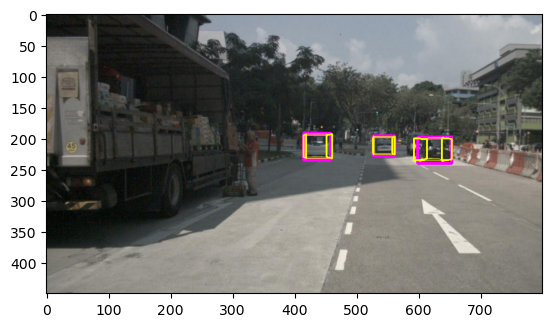

In [10]:
a = compute_once()
# [{'whl': tensor([1.6589, 1.5237, 4.2896], device='cuda:0'), 'theta': tensor(-0.3969, device='cuda:0'),'xyz': tensor([-6.1242,  0.6687, 14.5980], device='cuda:0')}, 
# {'whl': tensor([1.6450, 1.4545, 3.8156], device='cuda:0'), 'theta': tensor(1.6459, device='cuda:0'),'xyz': tensor([-3.7731,  0.5764, 24.4650], device='cuda:0')}, 
# {'whl': tensor([1.5986, 1.3893, 3.8987], device='cuda:0'), 'theta': tensor(-1.3671, device='cuda:0'),'xyz': tensor([ 4.5007,  0.6426, 13.1691], device='cuda:0')}, 
# {'whl': tensor([1.6694, 1.4892, 3.8727], device='cuda:0'), 'theta': tensor(-1.5278, device='cuda:0'),'xyz': tensor([ 6.4707,  0.0725, 44.8810], device='cuda:0')}, 
# {'whl': tensor([1.6569, 1.4752, 3.6818], device='cuda:0'), 'theta': tensor(1.5665, device='cuda:0'),'xyz': tensor([2.0021e+00, 2.5378e-02, 4.3136e+01], device='cuda:0')}, 
# {'whl': tensor([1.6895, 1.6075, 4.0574], device='cuda:0'), 'theta': tensor(1.1510, device='cuda:0'),'xyz': tensor([-4.8725, -0.1420, 42.9740], device='cuda:0')}]


[{'whl': tensor([1.9837, 1.7388, 4.3121], device='cuda:0'), 'theta': tensor(1.6118, device='cuda:0'), 'score': tensor(0.9986, device='cuda:0'), 'type_name': 'Car', 'xyz': tensor([ 3.8822,  0.2190, 45.8162], device='cuda:0')}, {'whl': tensor([2.0319, 1.6631, 4.6541], device='cuda:0'), 'theta': tensor(1.8908, device='cuda:0'), 'score': tensor(0.9985, device='cuda:0'), 'type_name': 'Car', 'xyz': tensor([ 7.0650,  0.3238, 40.4920], device='cuda:0')}, {'whl': tensor([1.9385, 1.7444, 4.1881], device='cuda:0'), 'theta': tensor(-1.6362, device='cuda:0'), 'score': tensor(0.9795, device='cuda:0'), 'type_name': 'Car', 'xyz': tensor([-1.9972,  0.1635, 38.2158], device='cuda:0')}]


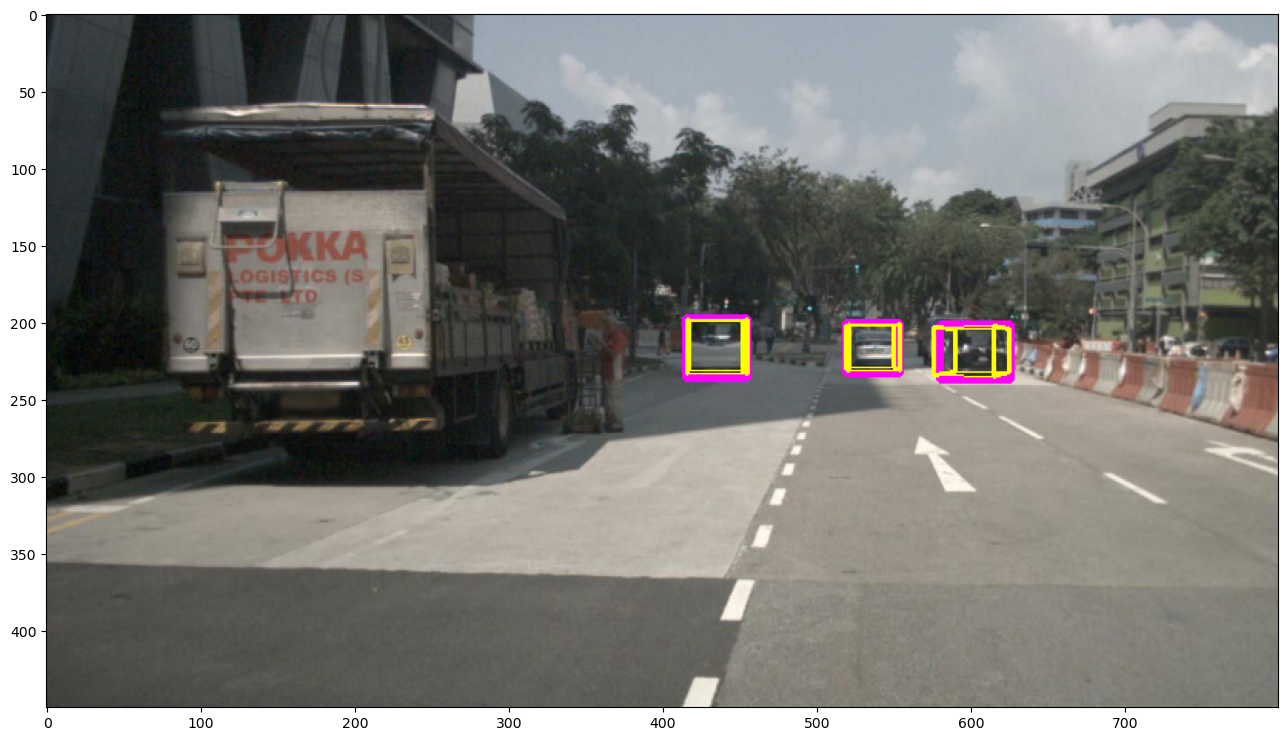

In [8]:
#%matplotlib inline
fig = plt.figure(figsize=(16,9))
a = compute_once(is_test_train=False, is_draw=True)

```python
centers = np.array([[1.50, 1.57, 1.625, 1.67, 1.72],
                    [1.42, 1.46,  1.50, 1.58, 1.66],
                    [3.43, 3.63,  3.89, 4.17, 4.47]]) #[3, 5]
```

length-->x axis //
width-->y axis //
height-->z axis //
theta γωνια μεταξυ x-z (2D επιπεδο)

In [78]:
# from visualDet3D.data.pipeline import build_augmentator

# def denorm(image):
#     new_image = ((image * cfg.data.augmentation.rgb_std + cfg.data.augmentation.rgb_mean) * 255).transpose(1, 2, 0).astype(np.uint8)
#     return new_image

# def collate_fn(batch):
#     rgb_images = np.array([item["image"] for item in batch])#[batch, H, W, 3]
#     rgb_images = rgb_images.transpose([0, 3, 1, 2])

#     calib = [item["calib"] for item in batch]
#     return torch.from_numpy(rgb_images).float(), torch.tensor(calib).float()

# def compute_once(is_draw=True, is_test_train=True):
#     transform = build_augmentator(cfg.data.test_augmentation)
#     #print("calibr.copy", calibr.copy()) swsto
#     transformed_image, transformed_P2 = transform(image.copy(), p2=calibr.copy())
#     #print("transformedP2A", transformed_P2) lathos
#     data = {'calib': transformed_P2,
#                        'image': transformed_image,
#                        'original_shape':image.shape,
#                        'original_P':calibr.copy()}
    
#     collated_data = collate_fn([data])
#     #print(collated_data)
     
#     test_func = PIPELINE_DICT[cfg.trainer.test_func]
#     with torch.no_grad():
#         scores, bbox, obj_names = test_func(collated_data, detector, None, cfg=cfg)       
#         bbox_2d = bbox[:, 0:4]
#         bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
#         bbox_3d_state[:, 2] *= 1.0
#         bbox_3d_state_3d = backprojector(bbox_3d_state, transformed_P2) #[x, y, z, w,h ,l, alpha]
#         abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, bbox_3d_state_3d.new(transformed_P2))
#         print(transformed_P2)
        
#     original_P = calibr
#     scale_x = original_P[0, 0] / transformed_P2[0, 0]
#     scale_y = original_P[1, 1] / transformed_P2[1, 1]
    
#     shift_left = original_P[0, 2] / scale_x - transformed_P2[0, 2]
#     shift_top  = original_P[1, 2] / scale_y - transformed_P2[1, 2]
#     bbox_2d[:, 0:4:2] += shift_left
#     bbox_2d[:, 1:4:2] += shift_top

#     bbox_2d[:, 0:4:2] *= scale_x
#     bbox_2d[:, 1:4:2] *= scale_y

#     bbox_2d = bbox_2d.cpu().numpy()
#     bbox_3d_state_3d = bbox_3d_state_3d.cpu().numpy()
#     thetas = thetas.cpu().numpy()

#     objects = []
#     N = len(bbox)
#     for i in range(N):
#         obj = {}
#         obj['whl'] = bbox_3d_state_3d[i, 3:6]
#         obj['theta'] = thetas[i]
#         obj['score'] = scores[i]
#         obj['type_name'] = obj_names[i]
#         obj['xyz'] = bbox_3d_state_3d[i, 0:3]
#         objects.append(obj)
#     print(objects)  

#     rgb_image = denorm(transformed_image[0])
#     if len(scores) > 0:
#         rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d)
#         for box in bbox_3d_corner_homo:
#             box = box.cpu().numpy().T
#             rgb_image = draw_3D_box(rgb_image, box)
#     if is_draw:
#         plt.imshow(np.clip(rgb_image, 0, 255))


#     return np.clip(rgb_image, 0, 255)